In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Baseline model

In [2]:
df = pd.read_csv('data_clean.csv')

/tmp/ipython-input-535481788.py:1: DtypeWarning: Columns (85,86,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_clean.csv')


In [3]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(y_train.mean(), y_test.mean())

0.21401278310407115 0.21397804640822565


In [4]:
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = [('te',TargetEncoder()),('sc',StandardScaler()),('lr',LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=500,
    C= 0.05))]

pipe = Pipeline(pipeline)

pipe.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.05, class_weight='balanced',
                                    max_iter=500, penalty='l1',
                                    solver='liblinear'))])

In [5]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("Baseline ROC-AUC:", auc)

Baseline ROC-AUC: 0.7077085279931311


Coefficient inspection

In [6]:
log_reg = pipe.named_steps.lr

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": log_reg.coef_[0]
})


coef_df = coef_df.sort_values("coef", key=np.abs, ascending=False)

In [7]:
coef_df.head(20)

,feature,coef
70,term_num,0.272510
4,sub_grade,0.249147
3,grade,0.138876
43,mort_acc,0.135578
55,num_rev_tl_bal_gt_0,0.125306
84,pymnt_plan_y,0.118068
5,home_ownership,0.115133
33,acc_open_past_24mths,0.099108
1,int_rate,0.093459
71,avg_fico,0.092359


In [8]:
(coef_df["coef"] == 0).mean()

np.float64(0.13333333333333333)

l1 penalty set coefficients of about 2% features to 0

## XGBoost + SHAP

We keep sub_grade, drop grade

sub_grade already contains grade information

Reduces redundancy and noise

In [9]:
X = df.drop(columns=["loan_status", "grade"], errors="ignore")
y = df["loan_status"]

In [10]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [11]:
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])

pipeline2 = [('te',TargetEncoder()), ('sc', StandardScaler()), ('xgb', XGBClassifier(
    n_estimators=400,
    max_depth=5,
    min_child_weight=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    eval_metric="auc",
    random_state=42
))]

pipe_xgb = Pipeline(pipeline2)

pipe_xgb.fit(X_train, y_train)


Pipeline(steps=[('te', TargetEncoder()), ('sc', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=50, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Model Evaluation

In [12]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe_xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("XGBoost ROC-AUC:", auc)

XGBoost ROC-AUC: 0.7005854142322234


## KS statistic

In [13]:
import numpy as np
from scipy.stats import ks_2samp

ks = ks_2samp(
    y_pred_proba[y_test == 0],
    y_pred_proba[y_test == 1]
).statistic

print("KS:", ks)

KS: 0.3020981934805516


## SHAP: Explainability

In [14]:
import shap

X_test_transformed = pipe_xgb[:-1].transform(X_test.iloc[:500])

model = pipe_xgb.named_steps.xgb


In [15]:
X_test_transformed.shape

(500, 89)

In [16]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X.columns)
X_test_transformed_df.shape

(500, 89)

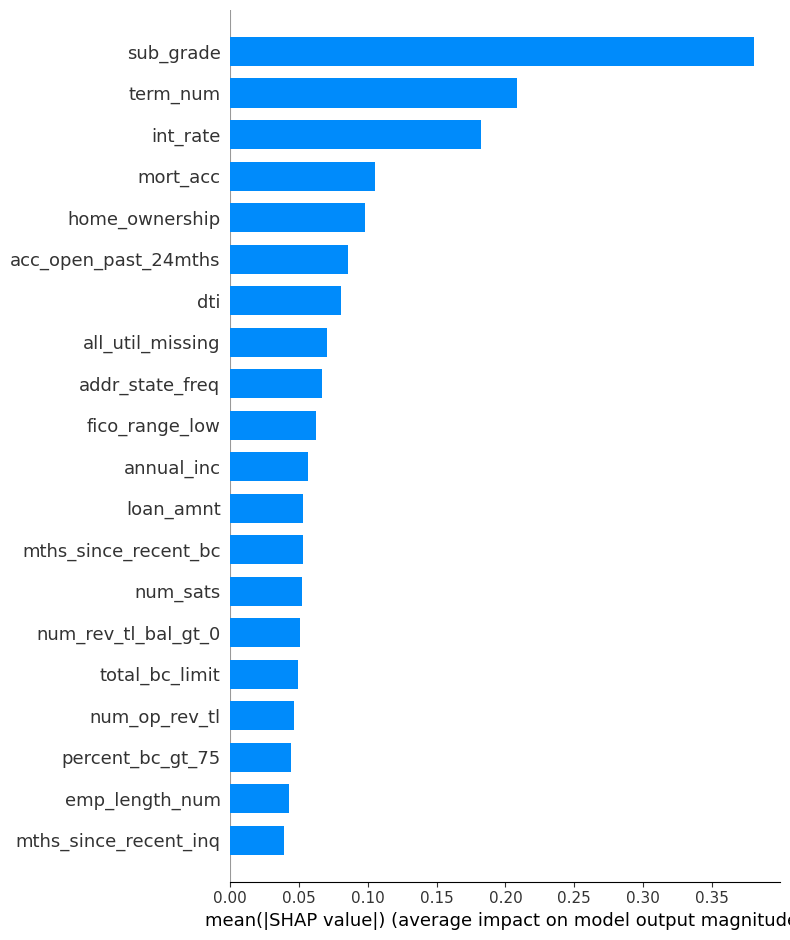

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed_df)


shap.summary_plot(shap_values, X_test_transformed_df, plot_type='bar')

## Directional Understanding

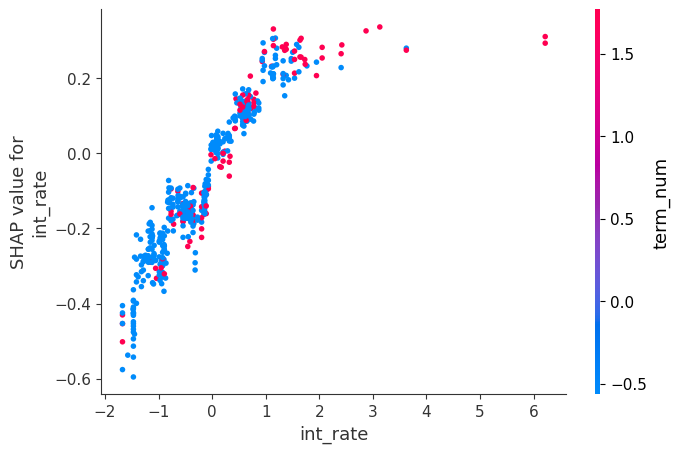

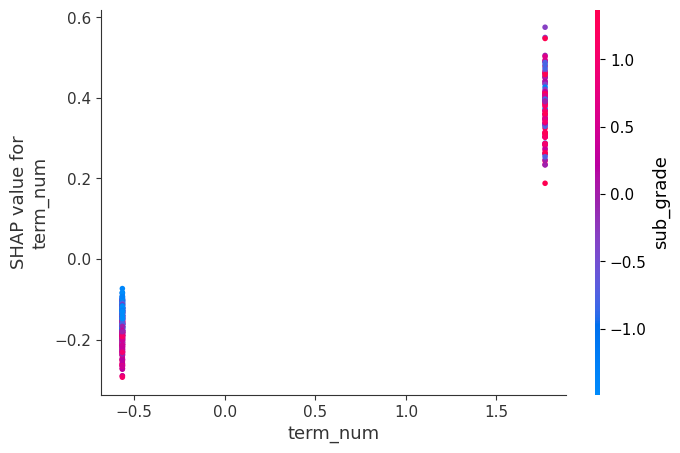

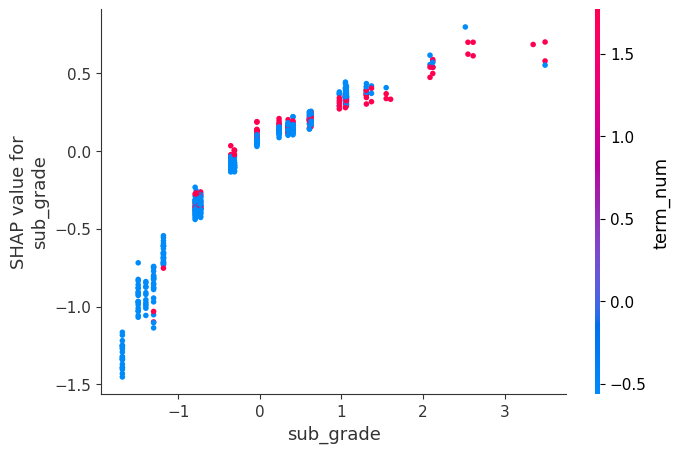

In [18]:
shap.dependence_plot("int_rate", shap_values, X_test_transformed_df)
shap.dependence_plot("term_num", shap_values, X_test_transformed_df)
shap.dependence_plot("sub_grade", shap_values, X_test_transformed_df)


#### Get SHAP values for one loan

In [19]:
i = 42  # loan index

loan = X_test_transformed_df.iloc[[i]]
shap_vals = explainer.shap_values(loan)

In [20]:
loan_shap = (
    pd.DataFrame({
        "feature": loan.columns,
        "value": loan.values[0,:],
        "shap": shap_vals[0,:]
    })
    .sort_values(by = 'shap', key=np.abs, ascending=False)
)


In [21]:
loan_shap.head(10)

,feature,value,shap
3,sub_grade,-1.302118,-0.741256
32,acc_open_past_24mths,-0.803936,-0.163245
55,num_sats,0.603392,-0.161308
68,emp_length_num,2.092310,0.149173
1,int_rate,-1.122805,-0.144995
35,bc_util,-1.755845,-0.143199
50,num_bc_tl,-1.633034,-0.123542
69,term_num,-0.565117,-0.119049
48,num_actv_rev_tl,0.908476,0.100323
66,addr_state_freq,0.084961,0.080828


Let us try to understand above table.

int_rate value is negative means below average so the borrower was offered a relatively low interest rate. This could be because Lender assesed this as low-risk.

sub_grade value is negative means better loan_grade by lender which means lender assessed this as low-risk.

acc_open_past_24mths value is negative which means below average. So not many accounts opened in last 24 months which reflects stable credit behaviour.

term_num value is negative which means a short-term loans. Short-terms loans have relatively lower risk which is reflected in SHAP value.

Almost all strong features push risk DOWN(Because of negative SHAP values)

Only annual income slightly increases risk

Net effect: model sees this as a relatively safer borrower

This borrower is predicted to be low risk primarily due to a low interest rate and strong loan grade, supported by stable credit behavior and manageable repayment obligations. Higher income slightly increases risk, but its impact is negligible compared to the dominant protective factors.

This is because `int_rate, sub_grade, acc_open_past_24mths, term_num` are features having highest impact on SHAP and all have negative SHAP values , ie, reduce risk.

In [22]:
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.5 MB/s eta 0:00:00


In [23]:
from skopt_hyperparam_tune import *

In [24]:
te = TargetEncoder(
    categories="auto",
    target_type="binary",
    smooth="auto"
)

X_train_te = te.fit_transform(X_train, y_train)

X_test_te = te.transform(X_test)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_te)
X_test_scaled = scaler.transform(X_test_te)



In [26]:

X_train_final = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)

X_test_final = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test.index
)

In [27]:
best_params = tune_xgb_credit_risk_cv(X_train_final, y_train)

final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=100,
    random_state=42,
    verbosity=0,
    n_jobs=-1,
    **best_params
)

final_model.fit(X_train_final, y_train)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.6654
Function value obtained: 0.5105
Current minimum: 0.5105
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 42.5311
Function value obtained: 0.6945
Current minimum: 0.5105
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.1547
Function value obtained: 0.4962
Current minimum: 0.4962
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.9662
Function value obtained: 0.5531
Current minimum: 0.4962
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.4312
Function value obtained: 0.7717
Current minimum: 0.4962
Iteration No: 6 started. Evalu

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08411895701432205,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(6), max_leaves=None,
              min_child_weight=np.int64(20), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

## Probability Calibration

In [31]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

calibrated_model = CalibratedClassifierCV(
    estimator=final_model,
    method="isotonic",
    cv=5
)

calibrated_model.fit(X_train_final, y_train)

# Compare
probs_before = final_model.predict_proba(X_test_final)[:, 1]
probs_after = calibrated_model.predict_proba(X_test_final)[:, 1]

print("Before Calibration:")
print("Log Loss:", log_loss(y_test, probs_before))
print("ROC_AUC Score:", roc_auc_score(y_test, probs_before))

print("\nAfter Calibration:")
print("Log Loss:", log_loss(y_test, probs_after))
print("ROC_AUC Score:", roc_auc_score(y_test, probs_after))

Before Calibration:
Log Loss: 0.5038913893989908
ROC_AUC Score: 0.6970258661260958

After Calibration:
Log Loss: 0.4752148171795921
ROC_AUC Score: 0.7049504808431801
